In [2]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np


In [6]:
# Poisson equation: -u_xx = f
def equation(x, y, f):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx - f


# Domain is interval [0, 1]
geom = dde.geometry.Interval(0, 1)


# Zero Dirichlet BC
def u_boundary(_):
    return 0


def boundary(_, on_boundary):
    return on_boundary


bc = dde.icbc.DirichletBC(geom, u_boundary, boundary)

# Define PDE
pde = dde.data.PDE(geom, equation, bc, num_domain=100, num_boundary=2)

# Function space for f(x) are polynomials
degree = 10
space = dde.data.Chebyshev(N=degree + 1)

# Choose evaluation points
num_eval_points = 40
evaluation_points = geom.uniform_points(num_eval_points, boundary=True)

# Define PDE operator
pde_op = dde.data.PDEOperatorCartesianProd(
    pde,
    space,
    evaluation_points,
    num_function=100,
)

In [7]:

# Setup DeepONet
dim_x = 1
p = 32
net = dde.nn.DeepONetCartesianProd(
    [num_eval_points, 32, p],
    [dim_x, 32, p],
    activation="tanh",
    kernel_initializer="Glorot normal",
)

# Define and train model
model = dde.Model(pde_op, net)
dde.optimizers.set_LBFGS_options(maxiter=1000)
model.compile("L-BFGS")
model.train()


Compiling model...
'compile' took 0.000314 s

Training model...

Step      Train loss              Test loss               Test metric
0         [2.06e+00, 5.85e-01]    [2.06e+00, 5.85e-01]    []  
1000      [2.48e-01, 1.72e-03]    [2.48e-01, 1.72e-03]    []  

Best model at step 1000:
  train loss: 2.50e-01
  test loss: 2.50e-01
  test metric: []

'train' took 184.632906 s



(<deepxde.model.LossHistory at 0x31a8d8210>,
 <deepxde.model.TrainState at 0x31da6fa50>)

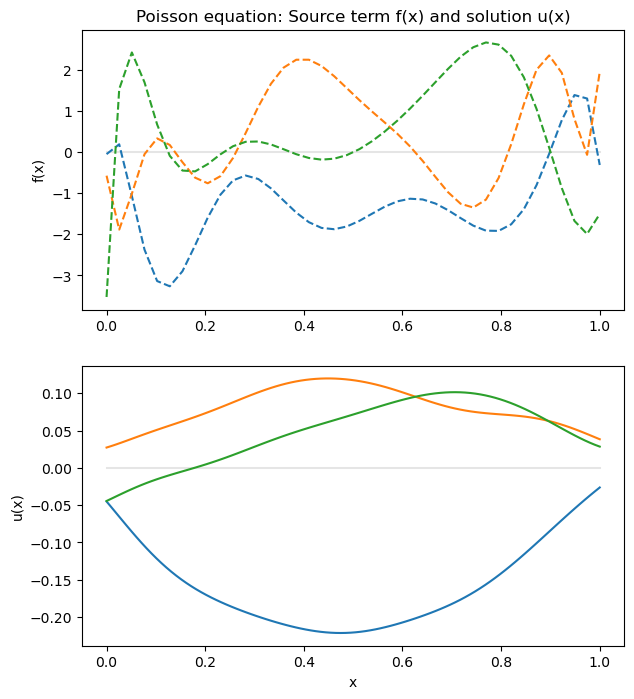

In [8]:

# Plot realisations of f(x)
n = 3
features = space.random(n)
fx = space.eval_batch(features, evaluation_points)

x = geom.uniform_points(100, boundary=True)
y = model.predict((fx, x))

# Setup figure
fig = plt.figure(figsize=(7, 8))
plt.subplot(2, 1, 1)
plt.title("Poisson equation: Source term f(x) and solution u(x)")
plt.ylabel("f(x)")
z = np.zeros_like(x)
plt.plot(x, z, "k-", alpha=0.1)

# Plot source term f(x)
for i in range(n):
    plt.plot(evaluation_points, fx[i], "--")

# Plot solution u(x)
plt.subplot(2, 1, 2)
plt.ylabel("u(x)")
plt.plot(x, z, "k-", alpha=0.1)
for i in range(n):
    plt.plot(x, y[i], "-")
plt.xlabel("x")

plt.show()

In [10]:
net.train_x

AttributeError: 'DeepONetCartesianProd' object has no attribute 'train_x'

In [12]:
dir(net)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_auxiliary_vars',
 '_backward_hooks',
 '_backward_pre_hooks',
 '_buffers',
 '_call_impl',
 '_compiled_call_impl',
 '_forward_hooks',
 '_forward_hooks_always_called',
 '_forward_hooks_with_kwargs',
 '_forward_pre_hooks',
 '_forward_pre_hooks_with_kwargs',
 '_get_backward_hooks',
 '_get_backward_pre_hooks',
 '_get_name',
 '_input_transform',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_post_hooks',
 '_load_state_dict_pre_hooks',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_nam

In [30]:
pde_op.test()[0][0].shape

(100, 40)